### Use kernel conda_tensorflow2_p310

In [145]:
%pip install tensorflow-probability --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import boto3
import numpy as np
import pandas as pd
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import feature_column
import tensorflow_probability as tfp
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

In [2]:
print(tf.__version__)

2.11.0


In [3]:
%run ./read_file.ipynb

:: loading settings :: url = jar:file:/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ec2-user/.ivy2/cache
The jars for the packages stored in: /home/ec2-user/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-bf128202-5ce2-4468-a50c-48056a56d502;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 308ms :: artifacts dl 8ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-----------------------------

23/04/01 16:09:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/01 16:09:17 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
23/04/01 16:09:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
# https://stackoverflow.com/questions/68036975/valueerror-shape-must-be-at-least-rank-3-but-is-rank-2-for-node-biasadd
# config for rank error in lstm
tf.config.threading.set_inter_op_parallelism_threads(16)
pd.set_option('display.max_columns', None)
tf.keras.backend.set_image_data_format("channels_last")

In [5]:
# Set Config
embedding_dim = 64
max_length = 6
sequence_length = 6
max_features = 10000
padding_type = 'post'
trunc_type = 'post'
training_portion = 0.8

hparams = {
    "batch_size": 128,
    "cnn_filter_sizes": [128, 128, 128],
    "cnn_kernel_sizes": [5, 5, 5],
    "cnn_pooling_sizes": [5, 5, 40],
    "constraint_learning_rate": 0.01,
    "embedding_dim": 100,
    "embedding_trainable": False,
    "learning_rate": 0.005,
    "max_num_words": 10000,
    "max_sequence_length": 250
}

In [6]:
METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [7]:
ds = spark.read.parquet("s3a://sapient-bucket-trusted/prod/tensor_sample_data/test_holdout/*").cache()

In [8]:
tot = ds.count()

In [9]:
dat = spark.read.parquet("s3a://sapient-bucket-trusted/prod/graph/encoded/sample3/*").cache()

In [10]:
tot2 = dat.count()

In [11]:
dat.groupBy("malicious") \
    .count() \
    .withColumnRenamed('count', 'cnt_per_group') \
    .withColumn('perc_of_count_total', (col('cnt_per_group') / tot2) * 100 ) \
    .sort("perc_of_count_total").show()

+---------+-------------+-------------------+
|malicious|cnt_per_group|perc_of_count_total|
+---------+-------------+-------------------+
|        1|         2338| 0.5007142352328922|
|        0|       464595|  99.49928576476711|
+---------+-------------+-------------------+



In [12]:
df = spark.read.parquet("s3a://sapient-bucket-trusted/prod/tensor_sample_data/test_holdout/*").cache().toPandas()

In [13]:
df.count()

Trace             2598111
malicious         2598111
event_sequence    2598111
dtype: int64

In [14]:
len(df)

2598111

In [15]:
df.dtypes

Trace              int64
malicious          int32
event_sequence    object
dtype: object

In [16]:
ds.groupBy("malicious") \
    .count() \
    .withColumnRenamed('count', 'cnt_per_group') \
    .withColumn('perc_of_count_total', (col('cnt_per_group') / tot) * 100 ) \
    .sort("perc_of_count_total").show()

+---------+-------------+-------------------+
|malicious|cnt_per_group|perc_of_count_total|
+---------+-------------+-------------------+
|        1|         6517|0.25083608821947945|
|        0|      2591594|  99.74916391178053|
+---------+-------------+-------------------+



In [17]:
# Data conversion - https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35
tokenizer = tf.keras.preprocessing.text.Tokenizer()

In [18]:
# https://stackoverflow.com/questions/39748660/how-to-perform-k-fold-cross-validation-with-tensorflow
def make_dataset(X_data,y_data,n_splits):

    def gen():        
        for train_index, test_index in KFold(n_splits).split(X_data):
            X_train, X_test = X_data[train_index], X_data[test_index] # input
            y_train, y_test = y_data[train_index], y_data[test_index] # labels
            
            X_train_seq = tokenizer.texts_to_sequences(X_train)
            X_train_ds = tf.reshape(X_train_seq, (len(X_train_seq),6,1))
            
            X_test_seq = tokenizer.texts_to_sequences(X_test)
            X_test_ds = tf.reshape(X_test_seq, (len(X_test_seq),6,1))
            
            y_test_ds = tf.ragged.constant(y_train)
            y_test_ds = tf.ragged.constant(y_test)
            
            
            yield X_train_ds,y_train_ds,X_test_ds,y_test_ds

    return tf.data.Dataset.from_generator(gen, (tf.float64,tf.float64,tf.float64,tf.float64))

In [19]:
df_events = df['event_sequence'].tolist()
df_labels = df['malicious'].tolist()

In [20]:
tokenizer.fit_on_texts(df_events)

In [21]:
# Get our training data word index
word_index = tokenizer.word_index
vocab_count = len(word_index)

In [22]:
dataset=make_dataset(df_events,df_labels,10)

In [23]:
# for X_train,y_train,X_test,y_test in iter(dataset):
#     print(1)

In [24]:
dataset

<FlatMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

In [25]:
iter(dataset.batch(8))

In [26]:
# print(train_sequences[10])

In [27]:
# train_size = int(len(df_labels) * training_portion)

# train_set = df_events[0: train_size]
# train_labels = df_labels[0: train_size]
# validation_set = df_events[train_size:]
# validation_labels = df_labels[train_size:]

In [28]:
train_set, validation_set, train_labels, validation_labels = train_test_split(df_events, df_labels,
                                                    stratify=df_labels, 
                                                    test_size=0.2)

In [29]:
Counter(train_labels)

Counter({0: 2073274, 1: 5214})

In [30]:
Counter(validation_labels)

Counter({0: 518320, 1: 1303})

In [31]:
# trains_ds = tfds.load('mnist', split=[
#     f'df_events[:{k}%]+train[{k+10}%:]' for k in range(0, 100, 10)
# ])
# vals_ds = tfds.load('mnist', split=[
#     f'df_events[{k}%:{k+10}%]' for k in range(0, 100, 10)
# ])

In [32]:
train_sequences = tokenizer.texts_to_sequences(train_set)
train_padded = tf.keras.utils.pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [33]:
validation_sequences = tokenizer.texts_to_sequences(validation_set)
validation_padded = tf.keras.utils.pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [34]:
validation_sequences[0]

[12419904, 12419905, 163298, 12419906, 12419907, 2647867]

In [35]:
validation_padded[0]

array([12419904, 12419905,   163298, 12419906, 12419907,  2647867],
      dtype=int32)

In [36]:
train_padded.shape

(2078488, 6)

In [37]:
validation_padded.shape

(519623, 6)

In [38]:
train_ds = tf.reshape(train_padded, (len(train_padded),6,1))

In [39]:
validation_ds = tf.reshape(validation_padded, (len(validation_padded),6,1))

In [40]:
train_labels_ds = tf.ragged.constant(train_labels)
validation_labels_ds = tf.ragged.constant(validation_labels)

In [41]:
train_ds.shape

TensorShape([2078488, 6, 1])

In [42]:
train_labels_ds.shape

TensorShape([2078488])

In [43]:
validation_ds.shape

TensorShape([519623, 6, 1])

In [44]:
validation_labels_ds.shape

TensorShape([519623])

In [ ]:
# https://keras.io/examples/keras_recipes/bayesian_neural_networks/
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
n = kernel_size + bias_size
prior_model = keras.Sequential(
    [
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.MultivariateNormalDiag(
                loc=tf.zeros(n), scale_diag=tf.ones(n)
            )
        )
    ]
)

In [ ]:
posterior_model = keras.Sequential(
    [
        tfp.layers.VariableLayer(
            tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
        ),
        tfp.layers.MultivariateNormalTriL(n),
    ]
)

In [45]:
# https://keras.io/examples/keras_recipes/bayesian_neural_networks/
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

In [46]:
# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [47]:
def create_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [48]:
hidden_units = [8, 8]
learning_rate = 0.001


def run_experiment(model, loss, train_dataset, test_dataset):

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Start training the model...")
    model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)
    print("Model training finished.")
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")

In [49]:
def create_baseline_model():
    inputs = create_model_inputs()
    input_values = [value for _, value in sorted(inputs.items())]
    features = keras.layers.concatenate(input_values)
    features = layers.BatchNormalization()(features)

    # Create hidden layers with deterministic weights using the Dense layer.
    for units in hidden_units:
        features = layers.Dense(units, activation="sigmoid")(features)
    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [50]:
dataset_size = 4898
batch_size = 256
train_size = int(dataset_size * 0.85)

In [55]:
model = tf.keras.models.Sequential()
model.add(layers.Embedding(vocab_count + 1, 16))
model.add(keras.layers.LSTM(500, input_shape=(train_ds.shape[1], train_ds.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(300, return_sequences=True))
model.add(keras.layers.LSTM(200))
model.add(keras.layers.Dense(train_ds.shape[2], activation='sigmoid'))

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[12463017,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [ ]:
model.summary()

In [140]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=METRICS)

In [141]:
history = model.fit(
                x=train_ds,
                y=train_labels_ds,
                batch_size=128,
                epochs=2,
                verbose=1,
                callbacks=None,
                validation_split=0.0,
                validation_data=(validation_ds, validation_labels_ds),
                shuffle=True,
                class_weight=None,
                sample_weight=None,
                initial_epoch=0,
                steps_per_epoch=None,
                validation_steps=None,
                validation_batch_size=None,
                validation_freq=1,
                max_queue_size=10,
                workers=1,
                use_multiprocessing=False
                )

Epoch 1/2
16239/16239 [==============================] - 393s 24ms/step - loss: 0.0179 - tp: 11731.0000 - fp: 2586380.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0045 - precision: 0.0045 - recall: 1.0000 - auc: 0.5000 - prc: 0.0045 - binary_accuracy: 0.0045 - val_loss: 0.0176 - val_tp: 1303.0000 - val_fp: 518320.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0025 - val_precision: 0.0025 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0025 - val_binary_accuracy: 0.0025
Epoch 2/2
16239/16239 [==============================] - 383s 24ms/step - loss: 0.0178 - tp: 5214.0000 - fp: 2073274.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0025 - precision: 0.0025 - recall: 1.0000 - auc: 0.5000 - prc: 0.0025 - binary_accuracy: 0.0025 - val_loss: 0.0175 - val_tp: 1303.0000 - val_fp: 518320.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0025 - val_precision: 0.0025 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0025 - val_binary_accuracy: 

In [58]:
# model.history.history

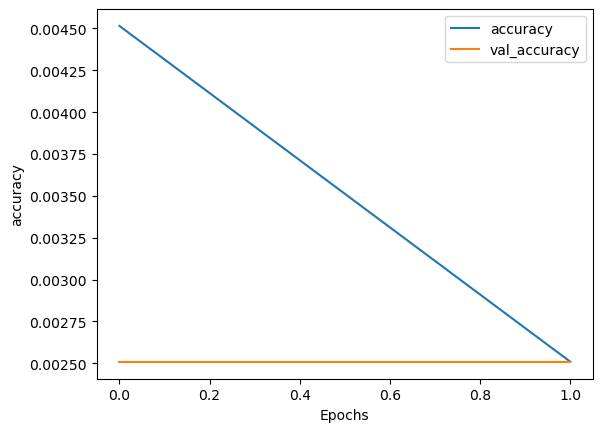

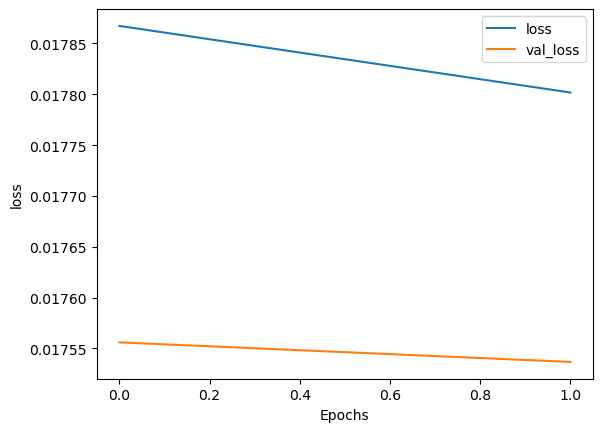

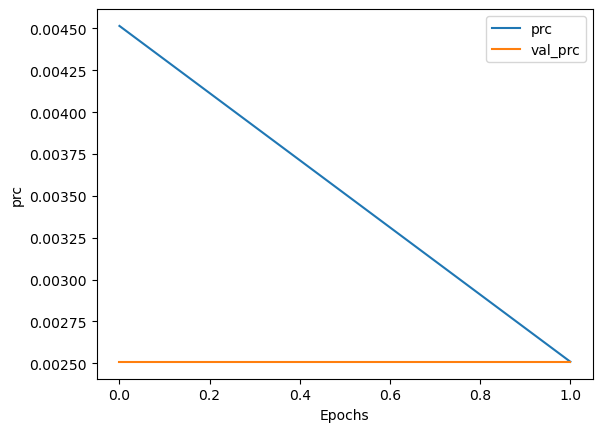

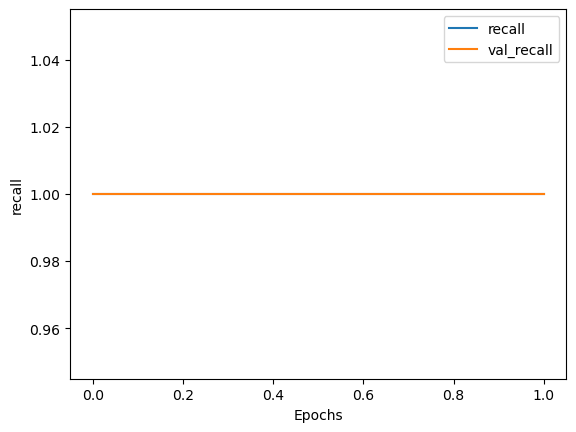

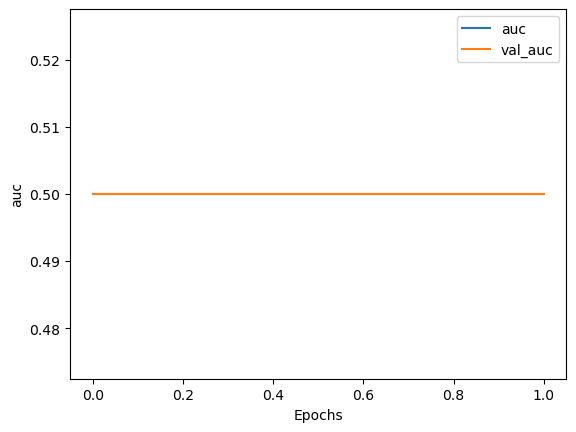

In [142]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
plot_graphs(history, "prc")
plot_graphs(history, "recall")
plot_graphs(history, "auc")

In [116]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(100 + 1, 128, input_length=6),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(1, activation='softmax')
])

ValueError: Input 0 of layer "bidirectional_12" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 128)

In [113]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 6, 128)            12928     
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 120,065
Trainable params: 120,065
Non-trainable params: 0
_________________________________________________________________


In [110]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [111]:
num_epochs = 2
history = model.fit(train_padded, train_ds, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_ds), 
                    verbose=1)

Epoch 1/2


ValueError: in user code:

    File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/losses.py", line 2176, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/backend.py", line 5680, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 1) vs (None, 6)).


In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# ds = tf.data.Dataset.from_tensor_slices(([i for i in df['event_sequence']], df['Trace'], df['malicious']))

In [ ]:
# Input data based on - https://www.tensorflow.org/tutorials/structured_data/feature_columns
train, test = train_test_split(df, test_size=0.2)

In [ ]:
train, val = train_test_split(train, test_size=0.2)

In [ ]:
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

In [ ]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('malicious')
  ds = tf.data.Dataset.from_tensor_slices(([i for i in df['event_sequence']], df['malicious']))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [ ]:
# A utility method to create a feature column
# and to transform a batch of data
def make_features(feature_column):  
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

In [ ]:
example_batch = next(iter(train))

In [ ]:
example_batch

In [ ]:
vocab_size = len(set([x[0] for x in df['event_sequence']] ))

In [ ]:
vocab_size

In [ ]:
# Vocabulary size and number of words in a sequence.
vocab_size = vocab_size
sequence_length = 6

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
text_ds = train_ds.map(lambda x, y: x)

In [ ]:
vectorize_layer.adapt(tf.reshape(text_ds, (len(text_ds),6,1)))

In [ ]:
for sequence_batch, label_batch in train_ds.take(1):
  print('A batch of sequences:', sequence_batch ) # list(feature_batch.keys()))
  print('A batch of targets:', label_batch )

In [ ]:
model = tf.keras.Sequential([
  #feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)